# 'P6_Plot_processing.ipynb' is created by Yue on 10/10/24 to plot the processing procedures.

Workflow:
1. Load pre-detrending u_ins data for one hour. 
2. Plot the time series of 10/10/20 at 1700 LT.
3. Rotate coordinate and get the mean and turbulence.
4. Low pass filter the time series of ux, uy, uz. (high pass correction)
5. Compare the power density before and after filtering.

# Set up environment

In [1]:
# This jupyter notebook command inserts matplotlib graphics in to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
from scipy import signal
import seaborn as sns
from scipy.signal import butter,sosfiltfilt,filtfilt
from scipy import fftpack
import math
import matplotlib.transforms as mtransforms

# Define parameters

In [2]:
# directories
# IN_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/basic_processed_data/"
IN_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_preprocessed_data/"
# Neutral_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_data_20200925_20210423/"
# IN_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_analysis_data_0707/"
FIG_DIR = '/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/save_fig_2rot/'
# global constants
sonum    =12                       # number of sonic
z  = np.array([1.2,2,3.5,6,9,12.5,16.5,23,30,40,50,60])  # height of sonic above ground, 
frequency=10                   # sampling rate, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop

list_all = np.arange(0,12)
ins_var=['u_ins','v_ins','w_ins'] # 36000 instantaneous variables per hour
# ins_var=['u_ins3d','v_ins3d','w_ins3d'] # 36000 instantaneous variables per hour
# neutral_var = ['neutral_case','u_avg_neutral','u_star_m2']
# Define azimuth angles for the sensors
azimuth_angles = [291.9, 298.2, 299.1, 300.8, 336.6, 337.9, 339.6, 339.6, 338.8, 337.2, 337.5, 340.3]

## PLOTTING STUFF
## define useful fonts
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
font_size = 16
do_plot = True
# ldg = np.array(['B2','B3','B4','A1','A2','A3'])
ldg = np.array(["12.5","16.5","23","30","40","50"])
color_list=sns.color_palette("tab10")

# Define functions

In [3]:
def psd_welch(ts_data,fs,exp):
    """
    one-sided by default, scaling to 'spectrum' where Pxx has units of V**2/Hz (e.g.,(m/s)**2/Hz), 
    if x is measured in V and fs is measured in Hz.
    """
    # replace nan by mean value
    x = ts_data
    x[np.argwhere(np.isnan(x))] = np.nanmean(ts_data)
    # timeseries is divided into segments of length equal to the value of 'nperseg'
    f0, Pxx_den0 = signal.welch(x, fs, nperseg=2**exp, detrend=False)
    # compute the correlation coefficient to 
    # check the energy loss due to windowing and averaging for FFT 
    df=f0[1]-f0[0]
    Cor0=np.nanmean((x-np.nanmean(x))**2)/np.nansum(Pxx_den0*df)
    # remove f=0
    return f0[1::],Pxx_den0[1::],Cor0


def butter_lowpass_filter(filt_type, data, cutoff, fs, order):
    """
    The frequency response of the Butterworth filter is maximally flat 
    (i.e. has no ripples) in the passband and rolls off towards zero in the stopband, 
    hence its one of the most popular low pass filter.
    """
    # replace nan by mean value
    data[np.argwhere(np.isnan(data))] = np.nanmean(data)
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    sos = butter(order, normal_cutoff, btype=filt_type, analog=False, output='sos',fs=fs)
    # Return the filtered output with the same shape as data
    # The function sosfiltfilt should be preferred over filtfilt 
    # for most filtering tasks, as second-order sections have fewer numerical problems.
    y = sosfiltfilt(sos, data) 
    return y

def butter_lowpass_filter(filt_type, data, cutoff, fs, order):
    """
    The frequency response of the Butterworth filter is maximally flat 
    (i.e. has no ripples) in the passband and rolls off towards zero in the stopband, 
    hence its one of the most popular low pass filter.
    """
    # Compute the normal cutoff frequency
    normal_cutoff = cutoff / nyq
    
    # Check that normal_cutoff is within (0, 1)
    if not 0 < normal_cutoff < 1:
        raise ValueError(f"Invalid cutoff frequency: {cutoff}. It must be between 0 and {nyquist} Hz.")
    
    # Count NaNs in the data and print the count
    nan_count = np.isnan(data).sum()
    if nan_count > 0:
        print(f"NaN count before interpolation: {nan_count}")
        # Interpolate NaN values in the data
        data = np.interp(np.arange(len(data)), np.arange(len(data))[~np.isnan(data)], data[~np.isnan(data)])
        # data[np.argwhere(np.isnan(data))] = np.nanmean(data)
    # Design the Butterworth filter
    sos = butter(order, normal_cutoff, btype=filt_type, analog=False, output='sos',fs=fs)
    
    # Debug: Print the filter coefficients
    # print("Second-order sections (sos):\n", sos)
    
    # Apply the filter
    # Return the filtered output with the same shape as data
    # The function sosfiltfilt should be preferred over filtfilt 
    # for most filtering tasks, as second-order sections have fewer numerical problems.
    try:
        y = sosfiltfilt(sos, data)
    except np.linalg.LinAlgError as e:
        print("Error during filtering:", e)
        print("Attempting to use sosfilt instead of sosfiltfilt.")
        y = sosfilt(sos, data)
    
    return y


def fft(data,fs):
    # replace nan by mean value
    data[np.argwhere(np.isnan(data))] = np.nanmean(data)
    # Return the Discrete Fourier Transform sample frequencies
    freq = np.abs(fftpack.fftfreq(data.size, 1/fs)) 
    # Return discrete Fourier transform of real or complex sequence x.
    # The returned complex array contains y(0), y(1),..., y(n-1), where
    # y(j) = (x * exp(-2*pi*sqrt(-1)*j*np.arange(n)/n)).sum()
    amp = np.abs(fftpack.fft(data))/ data.size   # |y(j)|
    den = amp**2 # energy density, |y(j))|**2
    df=freq[1]-freq[0]
    norm_den = den/df
    Cor=np.nanmean((data-np.nanmean(data))**2)/np.nansum(den)
    return freq,amp,norm_den,Cor

def wind_ang(ux,uy):
    """
    calculate mean wind angle on the xy-plane (!! must do before double rotation)
    The CSAT3 (the anemometer arms, tripods) is aligned northward and if u is positive, the wind is northerly. 
    If v is positive, the wind is westerly.
    u:north(+)->south(-), v:west(+)->east(-)
    """
    u_avg = np.nanmean(ux,axis=0) # size = 12
    v_avg = np.nanmean(uy,axis=0)
    rot_ang_v = np.arctan(v_avg/u_avg)
    rot_ang_v = rot_ang_v*360/2/math.pi
    mask1 = np.logical_and(u_avg>=0, v_avg<=0)
    rot_ang_v[mask1] = -rot_ang_v[mask1] # northeast
    mask2 = np.logical_and(u_avg<=0, v_avg<=0)
    rot_ang_v[mask2] = 180-rot_ang_v[mask2] # southest
    mask3 = np.logical_and(u_avg<=0, v_avg>=0)
    rot_ang_v[mask3] = 180-rot_ang_v[mask3] # southwest
    mask4 = np.logical_and(u_avg>=0, v_avg>=0)
    rot_ang_v[mask4] = 360-rot_ang_v[mask4] # northwest
    return rot_ang_v

def double_rot(ux,uy,uz):
    """
    Double rotation method (Note yaw correction must perform before pitch correction)
    https://www.licor.com/env/support/EddyPro/topics/anemometer-tilt-correction.html#:~:
    text=Double%20rotation%20method,by%20the%20flux%20averaging%20length.
    # such that the hourly avg of v and w will be zero
    # only u,v,w will be rotated, other variables remain the same
    """
    u_avg = np.nanmean(ux,axis=0) # size = 12
    v_avg = np.nanmean(uy,axis=0)
    w_avg = np.nanmean(uz,axis=0)
    # 1) yaw rotation (to remove v component)
    C1 = (u_avg**2 + v_avg**2) ** 0.5 # Magnitude of horizontal wind vector
    rot_mat_1 = u_avg/C1 # cos(theta)
    rot_mat_2 = v_avg/C1 # sin(theta)
    rot_mat_3 = -v_avg/C1
    rot_mat_4 = u_avg/C1
    u_rot = ux * rot_mat_1 + uy*rot_mat_2
    v_rot = ux * rot_mat_3 + uy*rot_mat_4
    u_ins_yawrot = u_rot # Intermediate rotated u after yaw correction
    v_ins_2rot = v_rot
    u_avg_yawrot = np.nanmean(u_ins_yawrot,axis=0) # Recompute u mean after yaw rotation
    # v_avg_2rot = np.nanmean(v_ins_2rot,axis=0)

    # 2) pitch rotation (to remove w component)
    C2 = (u_avg_yawrot**2 + w_avg**2) ** 0.5 # Magnitude of u-w plane vector
    rot_mat_1 = u_avg_yawrot/C2
    rot_mat_2 = w_avg/C2  # cos(phi)
    rot_mat_3 =-w_avg/C2  # sin(phi)
    rot_mat_4 = u_avg_yawrot/C2
    u_rot = u_ins_yawrot * rot_mat_1 + uz*rot_mat_2
    w_rot = u_ins_yawrot * rot_mat_3 + uz*rot_mat_4
    u_ins_2rot = u_rot
    w_ins_2rot = w_rot
    # u_avg_2rot = np.nanmean(u_ins_2rot,axis=0)
    # w_avg_2rot = np.nanmean(w_ins_2rot,axis=0)
    
    return u_ins_2rot,v_ins_2rot,w_ins_2rot

def fixer(y,thres):
    """
    remove spikes and fix them with the mean of its immediate neighbors.
    Following Vickers and Mahrt (1997), 
    https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html
    """
    qc = 0
    it = 0
    y_original = y.copy()
    while it < 20: # iterate 20 times
        # print(f"the {it} iterations:")
        # print(f"the 0 windows")
        y_sub = y[0:12000] # moving window is 20 min
        y_fix = y_sub.copy()
        spikes = abs(np.array(z_score(y_sub))) > thres
        n_con_spk = 0 # counts of more than 4 consecutive spikes
        for i in np.where(spikes != 0)[0]:  # If we have an spike in position i
            if i == 12000 - 1:
                w2 = np.arange(i-3,i+1)
                w1 = w2
            elif i == 12000 - 2:
                w2 = np.arange(i-4,i)
                w1 = np.arange(i-3,i+1)
            elif i == 12000 - 3:
                w2 = np.arange(i-5,i-1)
                w1 = np.arange(i-3,i+1)
            else:
                w1 = np.arange(i-3,i+1)
                w2 = np.arange(i,i+4)
            # 4 consecutive outliers
            # are considered as a local trend and not counted as a spike. 
            if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:
                # print(f"4 consecutive spikes.")
                n_con_spk += 1
            else:
                if i == 12000 - 1:
                    w = np.arange(12000-3,12000)
                else:
                    w = np.arange(i-1,i+2) # we select 3 points around our spike
                ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                y_fix[i] = np.mean(y_sub[ww]) # and we average their values
        # nspikes = np.nansum(spikes) - n_con_spk
        y_new = y_fix
        # 2nd to 6th moving window
        for iw in np.arange(1,5):
            n_con_spk = 0
            # print(f"the {iw} windows")
            y_sub = y[iw*6000:iw*6000+12000]
            y_fix = y_sub.copy()
            spikes = abs(np.array(z_score(y_sub))) > thres
            for i in np.where(spikes != 0)[0]:  # If we have an spike in position i
                if i >= 6000:
                    if i == 12000 - 1:
                        w2 = np.arange(i-3,i+1)
                        w1 = w2
                    elif i == 12000 - 2:
                        w2 = np.arange(i-4,i)
                        w1 = np.arange(i-3,i+1)
                    elif i == 12000 - 3:
                        w2 = np.arange(i-5,i-1)
                        w1 = np.arange(i-3,i+1)
                    else:
                        w1 = np.arange(i-3,i+1)
                        w2 = np.arange(i,i+4)
                    # 4 consecutive outliers
                    # are considered as a local trend and not counted as a spike. 
                    if np.sum(spikes[w1])==4 or np.sum(spikes[w2])==4:         
                        # print(f"4 consecutive spikes.")
                        n_con_spk += 1
                    else:
                        if i == 12000 - 1:
                            w = np.arange(12000-3,12000)
                        else:
                            w = np.arange(i-1,i+2) # we select 3 points around our spike
                        ww = w[spikes[w] == 0] # From such interval, we choose the ones which are not spikes
                        y_fix[i] = np.mean(y_sub[ww]) # and we average their values
            nspk = np.nansum(spikes[6000:12000]) - n_con_spk
            y_new = np.append(y_new,y_fix[6000:12000])
            # nspikes += nspk
        # print(f"{nspikes} spikes")
        # print("-----------")        
        # if it == 0:
        #     n_spikes = nspikes
        # else:
        n_spikes = np.sum((y_new-y_original)!=0)
        if n_spikes > 0.01*rpat: # accepted spikes is 1%
            qc = 1 # quality flag = 1, should be discarded from the results dataset.
            print("Too much number of spikes")
            break
        if n_spikes == 0:
            break
        y = y_new
        it += 1
    return y_new,qc,n_spikes

def z_score(intensity):
    """
    Z-score based approach for spike detection
    """
    mean_int = np.nanmean(intensity)
    std_int = np.nanstd(intensity)
    z_scores = (intensity-mean_int) / std_int
    return z_scores

def dtrd(data):
    # Only return the turbulent component  
    # The result is equal to signal.detrend(data)+np.mean(data)
    ct = np.arange(len(data))
    a = -(rpat*np.nansum(ct*data, axis=0) - np.nansum(ct, axis=0) * 
          np.nansum(data, axis=0)) / (np.nansum(ct**2, axis=0)-(np.nansum(ct, axis=0))**2)
    b = (np.nansum(data, axis=0) - a * np.nansum(ct, axis=0))/rpat
    data_dtr = data + (a*ct+b) - np.nanmean(data)
    c = -b + np.nanmean(data) # intercept of the line of trend
    return data_dtr,-a,c

# Load data with Double rotation

In [4]:
day = date(2020, 9, 25)
hour = 15
strday = str(day.strftime("%Y%m%d"))
print([day,hour])

for var in ins_var:
    with open(IN_DIR + var + '_' + strday + '.pkl', "rb") as a_file:
        globals()[var] = pickle.load(a_file)

# Reshape data to (24, 36000, 12)
u_ins3d = u_ins.reshape(-1, rpat, sonum)  # Shape: (24, 36000, 12)
v_ins3d = v_ins.reshape(-1, rpat, sonum)
w_ins3d = w_ins.reshape(-1, rpat, sonum)
print(u_ins3d.shape)

# select the disired hour
ux_ts = u_ins3d[hour,:,:] #36000,12
uy_ts = v_ins3d[hour,:,:]
uz_ts = w_ins3d[hour,:,:]

# # Step 1: Do azimuth correction 
# for il in range(sonum):
#     # Apply azimuth correction for each sensor
#     corrected_ux[:,il] = ux_ts[:,il] * np.cos(np.deg2rad(azimuth_angles[il])) + uy_ts[:,il] * np.sin(np.deg2rad(azimuth_angles[il]))
#     corrected_uy[:,il] = uy_ts[:,il] * np.cos(np.deg2rad(azimuth_angles[il])) - ux_ts[:,il] * np.sin(np.deg2rad(azimuth_angles[il]))

# Step 2: Do double rotation
u_2rot,v_2rot,w_2rot = double_rot(ux_ts,uy_ts,uz_ts)
# calculate mean u-velocity
u_avg_ux = np.nanmean(ux_ts,axis=0) # 12*1
print(u_avg_ux)
# u_avg_ux = np.nanmean(corrected_ux,axis=0) # 12*1
# print(u_avg_ux)
u_avg_2rot = np.nanmean(u_2rot,axis=0) # 12*1
print(u_avg_2rot)

# Step 3: Do linear detrending
# linear detrend
u_2rot_ldtr = np.zeros((36000,sonum)) * np.nan
a1 = np.zeros(sonum) * np.nan
a2 = np.zeros(sonum) * np.nan
for il in range(sonum):
    u_2rot_ldtr[:,il],a1[il],a2[il] = dtrd(u_2rot[:,il])
u_avg_2rot_ldtr = np.nanmean(u_2rot_ldtr,axis=0) # 12*1
print(u_avg_2rot_ldtr)

[datetime.date(2020, 9, 25), 15]
(24, 36000, 12)
[ 4.47386957  4.30206821  4.87913515  5.08005721 -2.68996758 -3.1445117
 -3.6729177  -3.96122544 -3.66935743 -3.44722178 -3.66359726 -4.38482466]
[ 8.16258667  9.52452934 11.11297539 12.3415906  13.30357112 14.79040472
 15.22096719 16.63206319 16.97789016 17.72149465 17.96814315 19.16165717]
[ 8.16258667  9.52452934 11.11297539 12.3415906  13.30357112 14.79040472
 15.22096719 16.63206319 16.97789016 17.72149465 17.96814315 19.16165717]


In [6]:
u_avg_2rot[5]

14.790404724885942

# Filter noise with a low pass filter

0.007
142


(-15.0, 15.0)

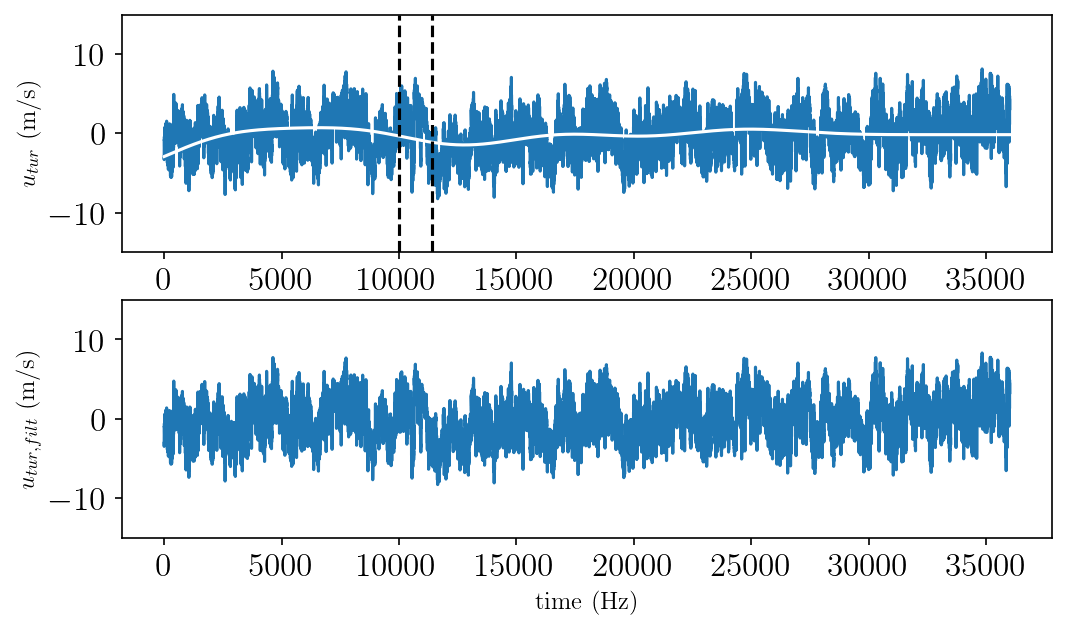

In [6]:
# Filter requirements.
T = time_avg         # Sample Period
l_cutoff = 2000      # cutoff wavelength, m
# Plot the sixth level (12.5m)
cutoff = round(abs(u_avg_2rot[5]/l_cutoff),3)     # desired cutoff frequency of the filter, Hz
print(cutoff)
filt_size = int(1/cutoff) # seconds
print(filt_size)
nyq = 0.5 * frequency  # Nyquist Frequency
order = 10       # filter order
n = int(T * frequency) # total number of samples

# Filter the data, and plot both the original and filtered signals.
# ts = u_2rot[:,5]
# low = butter_lowpass_filter('low', ts, cutoff, frequency, order)
# ts_filt = ts-low

# Filter the turbulent component
ts = u_2rot[:,5]-u_avg_2rot[5]
low = butter_lowpass_filter('low', ts, cutoff, frequency, order)
ts_filt = ts-low

# linear detrend
ts_ldtr,a1,a2 = dtrd(ts)

fig = plt.figure(figsize=(8, 7), dpi=150)
ax1 = fig.add_subplot(311) 
plt.plot(ts)
# plt.plot(ts_filt)
plt.plot(low,color='white')
plt.axvline(x=10000, color='black', linestyle='--')
plt.axvline(x=10000+filt_size*10, color='black', linestyle='--')
# plt.xlabel(r'\rm time (s)', fontsize = font_size)
plt.ylabel(r'\rm $u_{tur}$ (m/s)', fontsize = font_size)
plt.ylim(-15,15)

ax2 = fig.add_subplot(312) 
plt.plot(ts_ldtr)
# plt.plot(ts_dspk_filt)
plt.xlabel(r'\rm time (Hz)', fontsize = font_size)
plt.ylabel(r'\rm $u_{tur,filt}$ (m/s)', fontsize = font_size)
plt.ylim(-15,15)

# ax3 = fig.add_subplot(313) 
# plt.plot(ts_dspk)
# plt.plot(low_dspk,color='white')
# plt.xlabel(r'\rm time (Hz)', fontsize = font_size)
# plt.ylabel(r'\rm $u_{tur,dspk}$ (m/s)', fontsize = font_size)
# plt.ylim(-15,15)

# Welch method for the filtered ts

1.0308929498422448


(0.0013961949845101792, 2000)

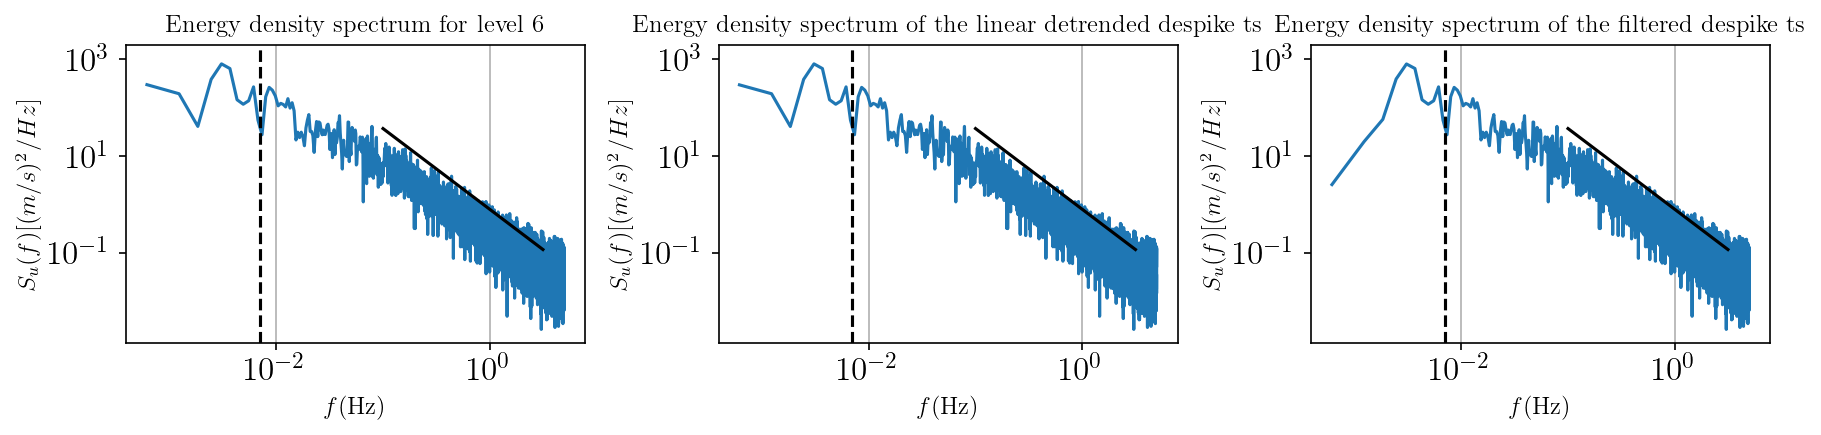

In [7]:
wid = 8 # the number of windows
n1=floor(rpat/wid)
n2=floor(log2(n1))
n2 = 14
f_u,Puu_den,Cor_uu = psd_welch(ts,frequency,n2) # for the original data
f_u_filt,Puu_den_filt,Cor_uu_filt = psd_welch(ts_filt,frequency,n2) # for the filtered data
# f_u_dspk_filt,Puu_den_dspk_filt,Cor_uu_dspk_filt = psd_welch(ts_dspk_filt,frequency,n2) # for the filtered despike data
f_u_dtr,Puu_den_dtr,Cor_uu_dtr = psd_welch(ts_ldtr,frequency,n2) # for the detrended data
print(Cor_uu_filt)
# print(Cor_uu_dspk_filt)
fig = plt.figure(figsize=(12, 3), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(131) 
plt.loglog(f_u,Puu_den)
x = np.logspace(-1, 0.5, num=50)
y = 0.8*x**(-5/3)
plt.loglog(x, y, '-',color='black')
plt.xlabel(r'$f$(Hz)', fontsize = font_size)
plt.ylabel(r'$S_{u}(f)[(m/s)^2/Hz]$', fontsize = font_size)
plt.axvline(x=cutoff,linestyle='--',color='black')
plt.grid(which='both', axis='x')
ax1.set_title('Energy density spectrum for level 6')
plt.ylim(0,2000)

ax2 = fig.add_subplot(132) 
plt.loglog(f_u_dtr,Puu_den_dtr)
x = np.logspace(-1, 0.5, num=50)
y = 0.8*x**(-5/3)
plt.loglog(x, y, '-',color='black')
plt.xlabel(r'$f$(Hz)', fontsize = font_size)
plt.ylabel(r'$S_{u}(f)[(m/s)^2/Hz]$', fontsize = font_size)
plt.axvline(x=cutoff,linestyle='--',color='black')
plt.grid(which='both', axis='x')
ax2.set_title('Energy density spectrum of the linear detrended despike ts')
plt.ylim(0,2000)

ax3 = fig.add_subplot(133) 
plt.loglog(f_u_filt,Puu_den_filt)
x = np.logspace(-1, 0.5, num=50)
y = 0.8*x**(-5/3)
plt.loglog(x, y, '-',color='black')
plt.xlabel(r'$f$(Hz)', fontsize = font_size)
plt.ylabel(r'$S_{u}(f)[(m/s)^2/Hz]$', fontsize = font_size)
plt.axvline(x=cutoff,linestyle='--',color='black')
plt.grid(which='both', axis='x')
ax3.set_title('Energy density spectrum of the filtered despike ts')
plt.ylim(0,2000)

# Plot ts and density spectrum

In [9]:
font_size

16

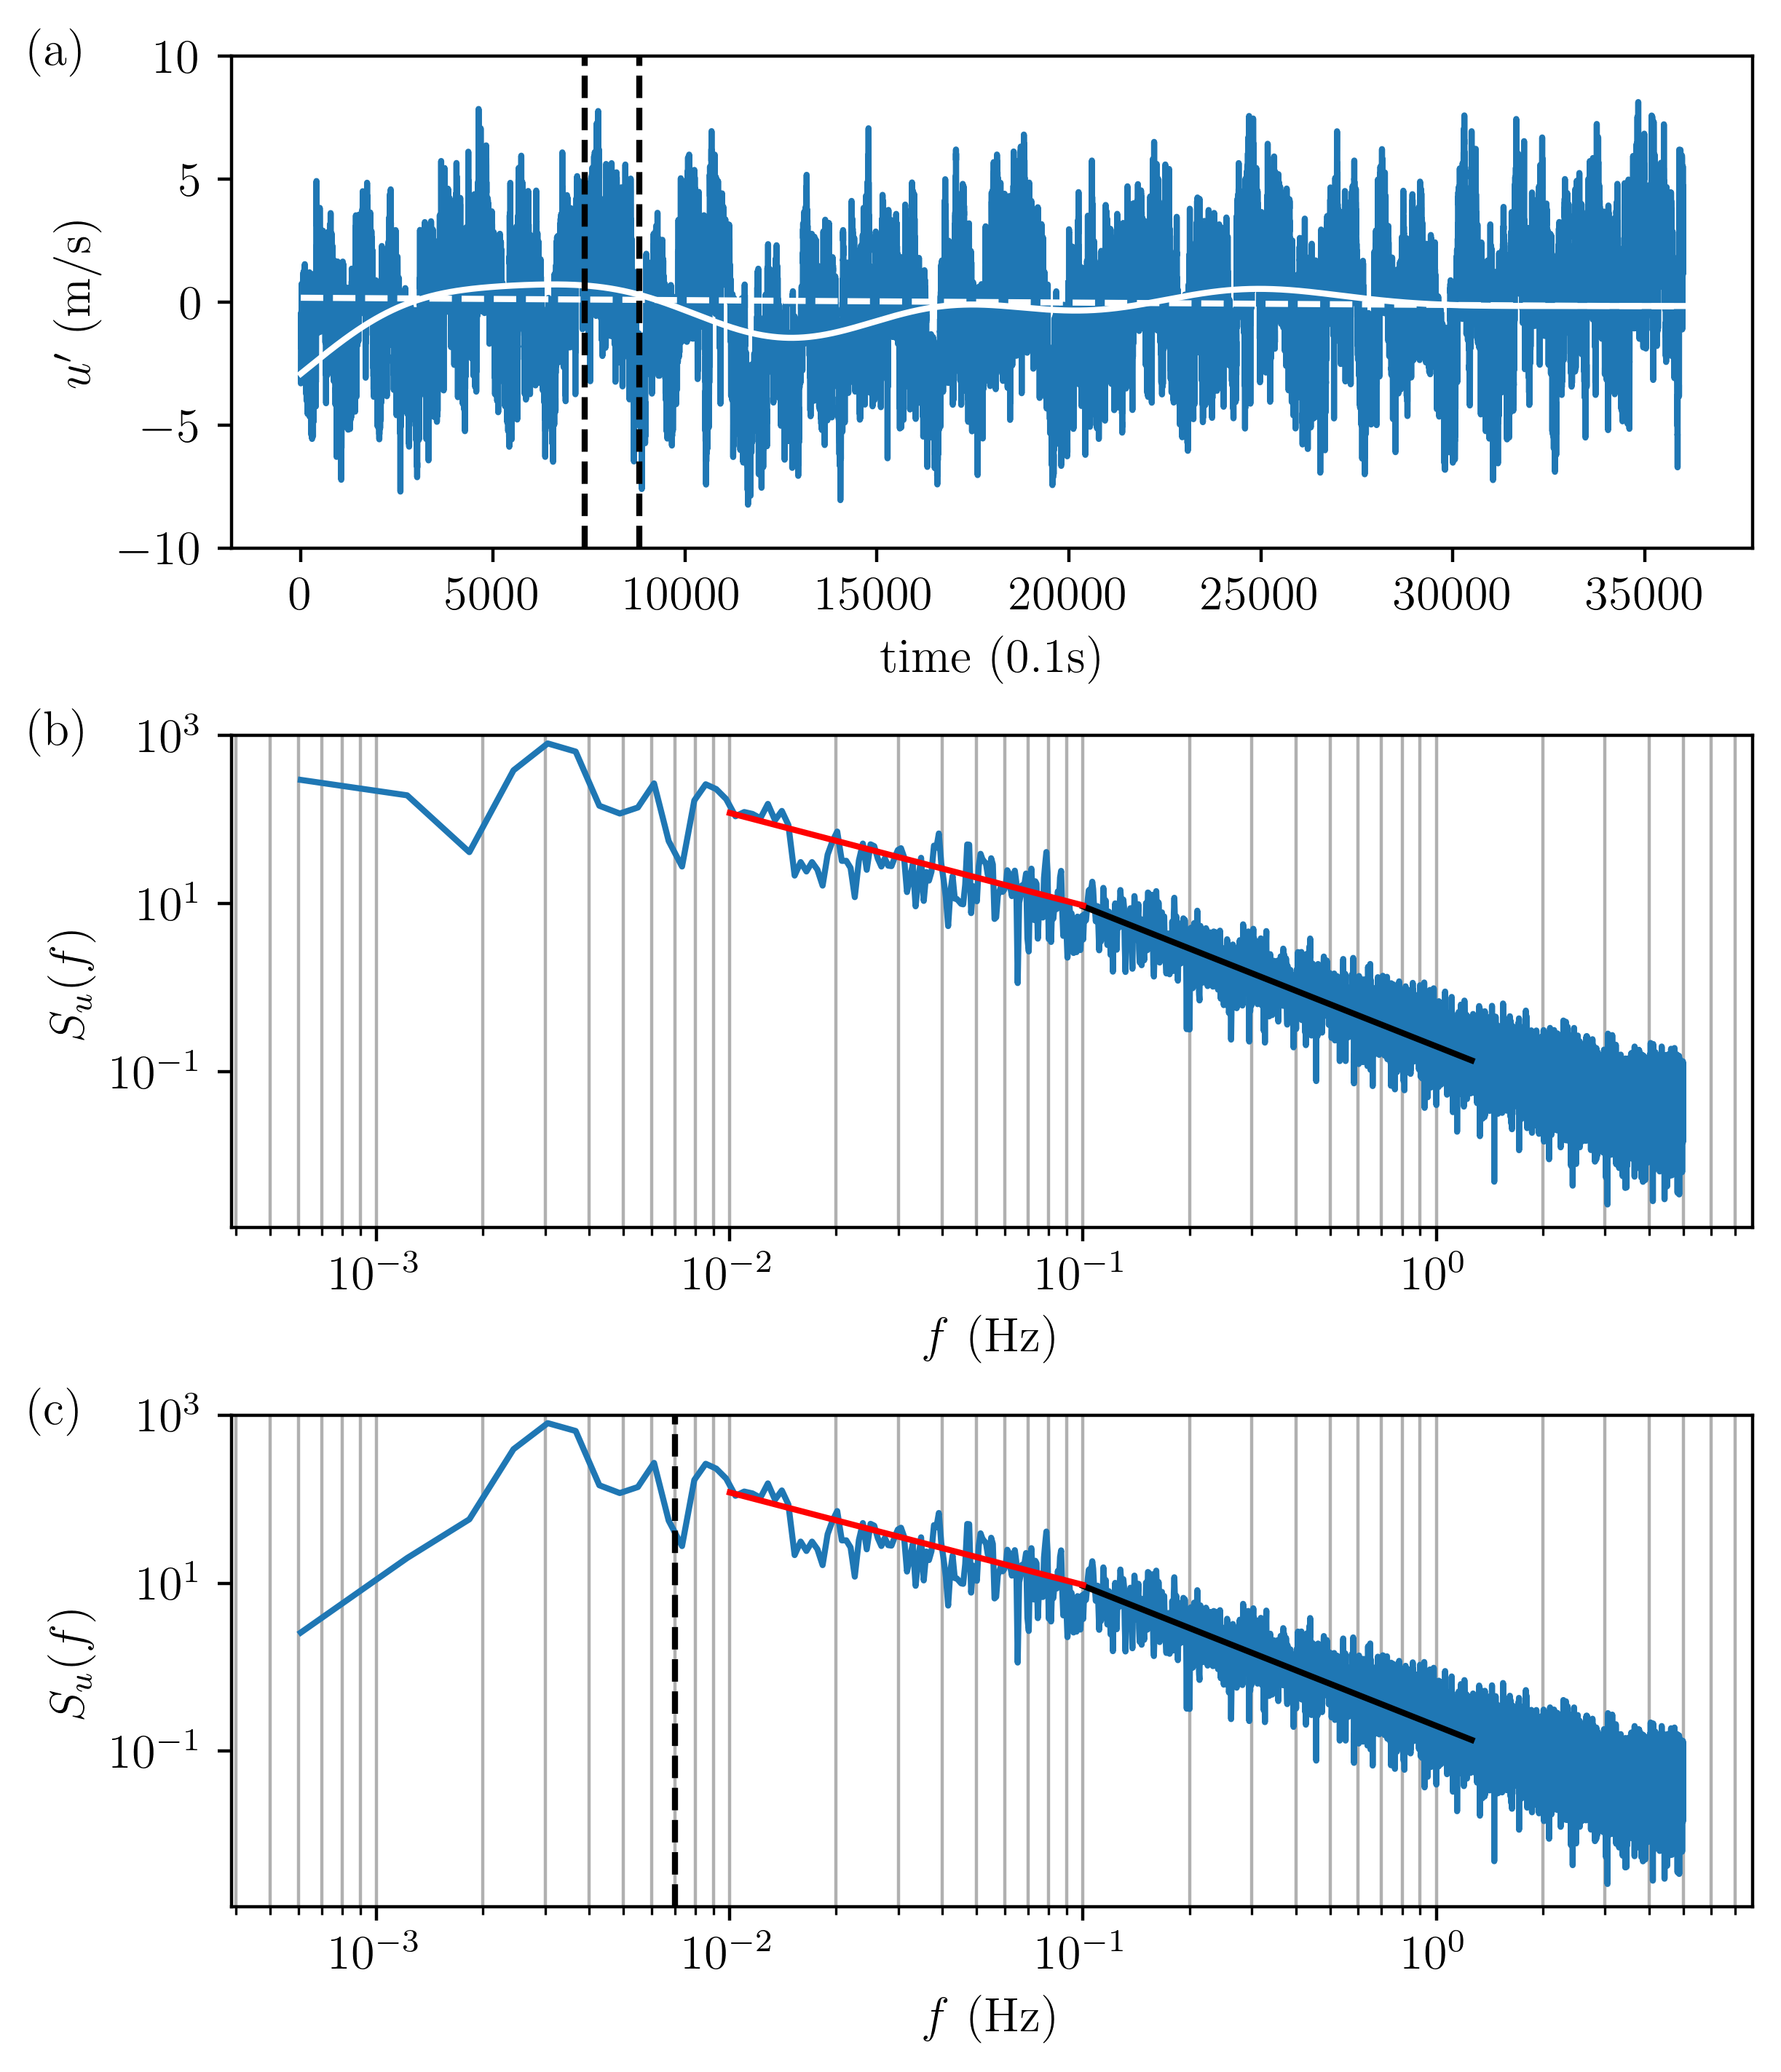

In [9]:
fig, axes = plt.subplot_mosaic([['a'],['b'],['c']], constrained_layout=True)
fig.set_size_inches(6,7)
fig.set_dpi(400)
font_size = 12
txt_loc = (-0.08, 0.9)
# label physical distance in and down:
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
t = np.linspace(0,35999,36000)
# axes['a'].plot(ux_ts[:,5])# 18LT at level6
# axes['a'].plot(t[ux_dspk[:,5]-ux_ts[:,5]!=0],ux_ts[ux_dspk[:,5]-ux_ts[:,5]!=0,5]
#          ,marker = 'o',markerfacecolor='none',linestyle = 'None')
# axes['a'].set_xlabel(r'\rm time (0.1s)', fontsize = font_size)
# axes['a'].set_ylabel(r'\rm $u$ (m/s)', fontsize = font_size)
# axes['a'].set_ylim(-14,12)
# axes['a'].text(-0.05, 0.9, '(a)', transform=axes['a'].transAxes + trans,
#                 fontsize=14, va='bottom')

ts_ldtr,a1,a2 = dtrd(ts)
axes['a'].plot(ts)
axes['a'].plot(low,color='white')
axes['a'].plot(t,a1*t+a2,color='white', linestyle='--')
axes['a'].axvline(x=7400, color='black', linestyle='--')
axes['a'].axvline(x=7400+filt_size*10, color='black', linestyle='--')
axes['a'].set_xlabel(r'\rm time (0.1s)', fontsize = font_size)
axes['a'].set_ylabel(r'\rm $u^\prime$ (m/s)', fontsize = font_size)
axes['a'].tick_params(axis='both', labelsize=font_size)
axes['a'].set_ylim(-10,10)
axes['a'].text(txt_loc[0], txt_loc[1], '(a)', transform=axes['a'].transAxes + trans,
                fontsize=font_size, va='bottom')

axes['b'].loglog(f_u_dtr,Puu_den_dtr)
x = np.logspace(-1, 0.1, num=50)
y = 0.2*x**(-5/3)
axes['b'].loglog(x, y, '-',color='black')
x2 = np.logspace(-2, -1, num=50)
y2 = 12*x**(-1)
axes['b'].loglog(x2, y2, '-',color='red')
axes['b'].set_xlabel(r'$f$ (Hz)', fontsize = font_size)
axes['b'].set_ylabel(r'$S_{u}(f)$', fontsize = font_size)
axes['b'].tick_params(axis='both', labelsize=font_size)
# axes['c'].axvline(x=cutoff,linestyle='--',color='black')
axes['b'].grid(which='both', axis='x')
# axes['c'].set_title('Energy density spectrum of the linear detrended despike ts')
axes['b'].set_ylim(0,1000)
axes['b'].text(txt_loc[0], txt_loc[1], '(b)', transform=axes['b'].transAxes + trans,
                fontsize=font_size, va='bottom')


axes['c'].loglog(f_u_filt,Puu_den_filt)
x = np.logspace(-1, 0.1, num=50)
y = 0.2*x**(-5/3)
axes['c'].loglog(x, y, '-',color='black')
x2 = np.logspace(-2, -1, num=50)
y2 = 12*x**(-1)
axes['c'].loglog(x2, y2, '-',color='red')
axes['c'].set_xlabel(r'$f$ (Hz)', fontsize = font_size)
axes['c'].set_ylabel(r'$S_{u}(f)$', fontsize = font_size)
axes['c'].tick_params(axis='both', labelsize=font_size)
axes['c'].axvline(x=cutoff,linestyle='--',color='black')
axes['c'].grid(which='both', axis='x')
axes['c'].set_ylim(0,1000)
axes['c'].text(txt_loc[0], txt_loc[1], '(c)', transform=axes['c'].transAxes + trans,
                fontsize=font_size, va='bottom')

plt.savefig(FIG_DIR + 'processing_20200925_LT15.jpg', dpi=400)

# Pre-multiplied spectrum

In [ ]:
# normalized u energy density multiplied by frequency
den_uu_dim = f_u*Puu_den/(u_star_m2[nday]**2) 
den_uu_dim_filt = f_u_filt*Puu_den_filt/(u_star_m2[nday]**2) 
den_uu_dim_dspk_filt = f_u_dspk_filt*Puu_den_dspk_filt/(u_star_m2[nday]**2) 
den_uu_dim_dtr = f_u_dtr*Puu_den_dtr/(u_star_m2[nday]**2) 
f_u_dim = f_u*z[5]/u_star_m2[nday]
f_u_dim_filt = f_u_filt*z[5]/u_star_m2[nday]
f_u_dim_dspk_filt = f_u_dspk_filt*z[5]/u_star_m2[nday]
f_u_dim_dtr = f_u_dtr*z[5]/u_star_m2[nday]

fig = plt.figure(figsize=(12, 3), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(131) 
plt.loglog(f_u_dim,den_uu_dim)
x = np.logspace(0, 1.5, num=50)
y = 1.5*x**(-2/3)
plt.loglog(x, y, '-',color='black')
plt.xlabel(r'$fz_i/u_*$', fontsize = font_size)
plt.ylabel(r'$fS_{u}(f)/u_*^2$', fontsize = font_size)
plt.axvline(x=cutoff*z[5]/u_star_m2[nday],linestyle='--',color='black')
plt.grid(which='both', axis='x')
ax1.set_title('Energy density spectrum of the original ts')
plt.ylim(5e-2, 2)

ax1 = fig.add_subplot(132) 
plt.loglog(f_u_dim_filt,den_uu_dim_filt)
plt.xlabel(r'$fz_i/u_*$', fontsize = font_size)
plt.ylabel(r'$fS_{u}(f)/u_*^2$', fontsize = font_size)
# plt.axvline(x=cutoff,linestyle='--')
x = np.logspace(0, 1.5, num=50)
y = 1.5*x**(-2/3)
plt.loglog(x, y, '-',color='black')
plt.axvline(x=cutoff*z[5]/u_star_m2[nday],linestyle='--',color='black')
plt.grid(which='both', axis='x')
ax1.set_title('Energy density spectrum of the filtered ts')
plt.ylim(5e-2, 2)

ax3 = fig.add_subplot(133) 
plt.loglog(f_u_dim_dspk_filt,den_uu_dim_dspk_filt)
plt.xlabel(r'$fz_i/u_*$', fontsize = font_size)
plt.ylabel(r'$fS_{u}(f)/u_*^2$', fontsize = font_size)
# plt.axvline(x=cutoff,linestyle='--')
x = np.logspace(0, 1.5, num=50)
y = 1.5*x**(-2/3)
plt.loglog(x, y, '-',color='black')
plt.axvline(x=cutoff*z[5]/u_star_m2[nday],linestyle='--',color='black')
plt.grid(which='both', axis='x')
ax3.set_title('Energy density spectrum of the filtered despike ts')
plt.ylim(5e-2, 2)